In [1]:
import class_backtester
import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer
from sklearn.base import clone

import quantstats as qs
# pd.set_option('display.max_rows', None)

----
# 1. Preprocess the insample data

### Add necessary columns & perform data cleaning

In [2]:
training_df = pd.read_csv('training_df_extra_features.csv')
# Add duplicate beta factor columns for constraint purposes
training_df['cons_beta_mktrf'] = training_df['beta_mktrf']
training_df['cons_beta_smb'] = training_df['beta_smb']
training_df['cons_beta_hml'] = training_df['beta_hml']
training_df['cons_beta_mom'] = training_df['beta_mom']

# Adding portfolio betas for benchmark
training_df['vw'] = training_df['mktcap']/training_df.groupby(['date'])['mktcap'].transform('sum')
beta_list = ['beta_mktrf', 'beta_smb', 'beta_hml', 'beta_mom']
for beta in beta_list:
    training_df[f'{beta}_bench'] = training_df.groupby('date').apply(lambda df: df[beta] * df['vw']).reset_index().iloc[:, -1]
    training_df[f'{beta}_bench'] = training_df.groupby('date')[f'{beta}_bench'].transform(sum)
    
training_df['date'] = pd.to_datetime(training_df['date'])
training_df = training_df.dropna()
training_df = training_df.rename(columns = {'av_atmcall': 'iv_atmcall',
                                            'av_otmput': 'iv_otmput', 
                                            'av_otmcall': 'iv_otmcall'}
)

### Add winsorization pipeline

In [3]:
pipept = Pipeline([
    ('ws', class_backtester.Winsorize(level_winsorize = 0.025)),
    ('qt', PowerTransformer()),
    ('maxabs', MaxAbsScaler())
])

### Define features used for our linear models (Lasso, Ridge)

In [4]:
feature_names = list(training_df.columns)
list_to_remove = ["permno", "date", "secid"]
feature_names_final  = list(set(feature_names) - set(list_to_remove))

lag_features = [x for x in training_df.columns if 'lag' in x]
glb_features = [x for x in training_df.columns if 'glb' in x]
mfis_features = [x for x in training_df.columns if 'mfis' in x]
beta_original_features = [x for x in training_df.columns if '_original' in x]

# these columns are not predictors 
not_modeling_features = ['permno', 'date', 'secid', 'fret1d'] + beta_original_features

# these columns should not be winsorized
# glb and mfis features are already winsorized (0.025 level for each maturity on the monthly basis)
columns_to_not_preprocess = not_modeling_features + glb_features + mfis_features + lag_features

preprocess_features = list(set(training_df.columns) - set(columns_to_not_preprocess))
modeling_features = list(set(training_df.columns) - set(not_modeling_features))

### Define features used for our non-linear models (XGBoost, Random Forest)

In [5]:
feature_names_nonlinear = [
       'mean2w', 'lag_10', 'lag_7', 'lag_4', 'lag_8', 'ret', 'mfis91', 'std2w',
       'lag_17', 'idvar_ff4', 'glb3_D30', 'lag_19', 'lag_16', 'glb3_D91',
       'mom12m', 'lag_14', 'glb2_D30', 'lag_5', 'lag_21', 'rev1m_squared',
       'av_atmcall_squared', 'lag_9', 'av_atmcall_av_otmput', 'lag_13',
       'lag_20', 'beta_mom', 'lag_15', 'lag_6', 'lag_1', 'lag_11', 'mom6m',
       'lag_18', 'glb2_D91', 'av_atmcall_av_otmcall', 'lag_12', 'lag_2',
       'rev1m', 'lag_3', 'skew'
]

nonlinear = training_df[feature_names_nonlinear]

lag_features = [x for x in nonlinear.columns if 'lag' in x]
glb_features = [x for x in nonlinear.columns if 'glb' in x]
mfis_features = [x for x in nonlinear.columns if 'mfis' in x]
beta_original_features = [x for x in nonlinear.columns if '_original' in x]

# # these columns are not predictors 
not_modeling_features = ['permno', 'date', 'secid', 'fret1d'] + beta_original_features

# # these columns should not be winsorized
# # glb and mfis features are already winsorized (0.025 level for each maturity on the monthly basis)
columns_to_not_preprocess = not_modeling_features + glb_features + mfis_features + lag_features

preprocess_features_nonlinear = list(set(nonlinear.columns) - set(columns_to_not_preprocess))
modeling_features_nonlinear = list(set(nonlinear.columns) - set(not_modeling_features))


----
# 2. Run Backtesting on Insample Data

### Backtesting Configurations

In [6]:
msr_final_configs = { 
    # MSR Trading Strategy: 
    'msr_lasso': {'opt_function': class_backtester.MSR, 'alpha_estimation_method':'Lasso', "alpha": 0.010906, 'parsing': clone(pipept)}, # best
    'msr_lasso_default': {'opt_function': class_backtester.MSR, 'alpha_estimation_method':'Lasso', "alpha": 1.0, 'parsing': clone(pipept)},
    'msr_ridge': {'opt_function': class_backtester.MSR, 'alpha_estimation_method':'Ridge', "alpha": 0.037649, 'parsing': clone(pipept)},
    'msr_ridge_default': {'opt_function': class_backtester.MSR, 'alpha_estimation_method':'Ridge', "alpha":  1.0, 'parsing': clone(pipept)},
    'msr_ElasticNet_opt': {'opt_function': class_backtester.MSR, 'alpha_estimation_method':'Lasso', "alpha": 0.000237, "l1_ratio":  0.227680, 'parsing': clone(pipept)},
    'msr_ElasticNet_default': {'opt_function': class_backtester.MSR, 'alpha_estimation_method':'Lasso', "alpha": 1.0, "l1_ratio": 0.1, "parsing": clone(pipept)}
}

mvp_final_configs = { 
    # MVP Trading Strategy: 
    'mvp_lasso': {'opt_function': class_backtester.MVP, 'alpha_estimation_method':'Lasso', "alpha": 0.010906, 'parsing': clone(pipept)},
    'mvp_lasso_default': {'opt_function': class_backtester.MVP, 'alpha_estimation_method':'Lasso', "alpha": 1.0, 'parsing': clone(pipept)},
    'mvp_ridge': {'opt_function': class_backtester.MVP, 'alpha_estimation_method':'Ridge', "alpha": 0.037649, 'parsing': clone(pipept)},
    'mvp_ridge_default': {'opt_function': class_backtester.MVP, 'alpha_estimation_method':'Ridge', "alpha":  1.0, 'parsing': clone(pipept)}
}

ls_final_configs = { 
    # Long Short Strategy Trading Strategy: Both of them using optimized parameters
    'ls_lasso': {'opt_function': class_backtester.LS, 'alpha_estimation_method':'Lasso', "alpha": 0.010906, 'parsing': clone(pipept)},
    'ls_ridge': {'opt_function': class_backtester.LS, 'alpha_estimation_method':'Ridge', "alpha": 0.037649, 'parsing': clone(pipept)}
}

# The XGBoost and random forest models require a different configuration because we will use a different
# set of features for these particular models.
xgboost_rforest_configs = {
    # MSR & MVP & LS Trading Strategy for XGBoost and Random Forest:
    'msr_xgboost': {'opt_function': class_backtester.MSR, 'alpha_estimation_method': 'xgboost', 'parsing': clone(pipept)},
    'msr_rforest': {'opt_function': class_backtester.MSR, 'alpha_estimation_method': 'random_forest', 'parsing': clone(pipept)},
    'mvp_xgboost': {'opt_function': class_backtester.MVP, 'alpha_estimation_method': 'xgboost', 'parsing': clone(pipept)},
    'ls_xgboost': {'opt_function': class_backtester.LS, 'alpha_estimation_method': 'xgboost', 'parsing': clone(pipept)}
}

### Run Backtester
If you would like to run other configurations in the Backtester, you need to change the `configurations` argument and possibly the `preprocess_features` and `modeling_features` argument depending on whether or not you are backtesting a linear or non-linear (XGBoost, Random Forest) model. The features chosen are different for the non-linear models.

In [ ]:
backtester = class_backtester.Backtester(
    df = training_df,
    params = None,
    optimise = True,
    preprocess_features = preprocess_features,
    modeling_features = modeling_features,
    rolling_frw = '1D',
    look_back_prm = 252,
    configurations = msr_final_configs,
    col_to_pred = 'fret1d',
    days_avoid_bias = 1
)
backtester.run_backtest()

In [ ]:
# After backtesting, save your results
utils.save_results(backtester, 'msr_linear')

----
# 3. Model/Trading Strategy Performance Analysis

### Create benchmark dataframe

In [7]:
benchmark = training_df.copy()
benchmark['ret_vw'] = benchmark['ret'] * benchmark['vw']
benchmark['return'] = benchmark.groupby(by = ['date'])['ret_vw'].transform(sum)
benchmark = benchmark.groupby(by = ['date']).first().reset_index()

### Compile returns

In [10]:
# Add benchmark returns
benchmark_returns = benchmark[['date', 'return']]
benchmark_returns['date'] = benchmark_returns['date'].dt.strftime('%Y-%m-%d')
benchmark_returns = benchmark_returns.rename(columns = {'return': 'benchmark'})

train_returns_ls_linear = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/ls_linear_opt_train_returns_df.csv')
train_returns_ls_xgboost = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/ls_xgboost_train_returns_df.csv')
train_returns_msr_elasticnet = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/msr_elasticNet_train_returns_df.csv')
train_returns_msr_lasso = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/msr_lasso_train_opt_returns_df.csv')
train_returns_msr_linear = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/msr_linear_train_returns_df.csv')
train_returns_msr_rf = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/msr_rf_train_returns_df.csv')
train_returns_msr_xgboost = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/msr_xgboost_train_returns_df.csv')
train_returns_mvp_linear = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/mvp_linear_train_returns_df.csv')
train_returns_mvp_xgboost = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/returns/mvp_xgboost_train_returns_df.csv')

# Concatenate returns
train_returns = pd.concat([benchmark_returns,
                           train_returns_ls_linear,
                           train_returns_ls_xgboost,
                           train_returns_msr_elasticnet,
                           train_returns_msr_lasso,
                           train_returns_msr_linear,
                           train_returns_msr_rf,
                           train_returns_msr_xgboost,
                           train_returns_mvp_linear,
                           train_returns_mvp_xgboost],
                          axis = 1)
train_returns = train_returns.loc[:, ~train_returns.columns.duplicated()]    
train_returns = train_returns.fillna(0.0)
train_returns = train_returns[train_returns['date'] >= '2000-09-11'] # 2000-09-11 is when predictions start due to the 252 day rolling window
train_returns = train_returns.drop(columns = 'Unnamed: 0')

train_returns = train_returns.set_index('date')

In [11]:
train_results = pd.DataFrame()
for config in list(train_returns.columns):
    results = utils.calculate_performance_metrics(train_returns, config, risk_free_rate = 0.0)
    train_results = pd.concat([train_results, results])

train_results = train_results.sort_values(by = ['max_drawdown', 'smart_sortino_ratio'], ascending = [False, True])
train_results = train_results.round(3)
train_results = train_results.reset_index(drop = True)
train_results

,model_&_strategy,max_drawdown,smart_sortino_ratio,cum_returns,sharpe_ratio,calmar,avg_loss,vol_annualized,win_loss_ratio
0,msr_lasso_opt,-37.225,0.573,121.20,0.440,0.143,-0.006,0.141,0.957
1,ls_xgboost,-37.295,0.571,120.64,0.439,0.142,-0.006,0.141,0.955
2,ls_ridge_opt,-37.493,0.571,120.54,0.439,0.141,-0.006,0.140,0.957
3,mvp_lasso,-37.508,0.574,121.23,0.441,0.142,-0.006,0.140,0.956
4,mvp_lasso_default,-37.508,0.574,121.23,0.441,0.142,-0.006,0.140,0.956
5,mvp_ridge,-37.508,0.574,121.23,0.441,0.142,-0.006,0.140,0.956
6,mvp_ridge_default,-37.508,0.574,121.23,0.441,0.142,-0.006,0.140,0.956
7,mvp_xgboost,-37.508,0.574,121.23,0.441,0.142,-0.006,0.140,0.956
8,msr_ridge,-37.733,0.557,115.78,0.428,0.137,-0.006,0.141,0.953
9,msr_ElasticNet_default,-37.862,0.573,121.26,0.440,0.141,-0.006,0.140,0.954


----
# 4. Plotting
We create plots for the 2 best and worst models from the results table.

* Best:
    * 1\. msr_lasso_opt
    * 2\. ls_xgboost
* Worst:
    * 1\. msr_ElasticNet_opt
    * 2\. msr_ridge_default

### Realized betas of portfolio from different models/trading strategies vs. benchmark

#### Compiled optimal weights

In [12]:
train_weights_msr_linear = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/weights/msr_linear_train_optimal_weights_df.csv')
train_weights_ls_xgboost = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/weights/ls_xgboost_train_weights_df.csv')
train_weights_msr_elasticnet = pd.read_csv('/Users/vinh/FS/quant_trading/group_project/training/weights/msr_elasticNet_train_optimal_weights_df.csv')

# Concatenate weights
train_weights = pd.concat([train_weights_msr_linear,
                           train_weights_ls_xgboost,
                           train_weights_msr_elasticnet],
                          axis = 1)
train_weights = train_weights.loc[:, ~train_weights.columns.duplicated()]    
train_weights = train_weights.fillna(0.0)
train_weights = train_weights[train_weights['date'] >= '2000-09-11'] # 2000-09-11 is when predictions start due to the 252 day rolling window
train_weights = train_weights.drop(columns = 'Unnamed: 0')
train_weights['date'] = pd.to_datetime(train_weights['date'])

### Merge optimal weights dataframe with benchmark
We need the betas for each permno for each date to calculate the portfolio betas for each model/trading strategy. We then multiply the weights with the betas and sum up all 50 permnos in our portfolio for each day.

In [13]:
temp = training_df.copy()
temp = temp[['permno', 'date', 'beta_mktrf', 'beta_smb', 'beta_hml', 'beta_mom', 'beta_mktrf_bench', 'beta_smb_bench', 'beta_hml_bench', 'beta_mom_bench']]

train_weights = pd.merge(train_weights, temp, on = ['permno', 'date'])

In [14]:
model_and_strategy_portfolio_betas = pd.DataFrame()
model_and_strategy = ['msr_lasso_opt', 'ls_xgboost', 'msr_ElasticNet_opt', 'msr_ridge_default']
for i in model_and_strategy:
    temp = pd.DataFrame({
        'permno': train_weights['permno'],
        'date': train_weights['date'],
        'beta_mktrf_bench': train_weights['beta_mktrf_bench'],
        'beta_smb_bench': train_weights['beta_smb_bench'],
        'beta_hml_bench': train_weights['beta_hml_bench'],
        'beta_mom_bench': train_weights['beta_mom_bench'],
        f'{i}_beta_mktrf': train_weights[i] * train_weights['beta_mktrf'],
        f'{i}_beta_smb': train_weights[i] * train_weights['beta_smb'],
        f'{i}_beta_hml': train_weights[i] * train_weights['beta_hml'],
        f'{i}_beta_mom': train_weights[i] * train_weights['beta_mom']
    })
    temp[f'{i}_beta_mktrf'] = temp.groupby('date')[f'{i}_beta_mktrf'].transform(sum)
    temp[f'{i}_beta_smb'] = temp.groupby('date')[f'{i}_beta_smb'].transform(sum)
    temp[f'{i}_beta_hml'] = temp.groupby('date')[f'{i}_beta_hml'].transform(sum)
    temp[f'{i}_beta_mom'] = temp.groupby('date')[f'{i}_beta_mom'].transform(sum)
    
    model_and_strategy_portfolio_betas = pd.concat([model_and_strategy_portfolio_betas, temp], axis = 1)
    
model_and_strategy_portfolio_betas = model_and_strategy_portfolio_betas.loc[:, ~model_and_strategy_portfolio_betas.columns.duplicated()]
model_and_strategy_portfolio_betas = model_and_strategy_portfolio_betas.groupby(by = ['date']).first().reset_index()

### Compute delta of the betas in the model/strategy with respective benchmark beta

In [25]:
# Create lists of beta columns for each model/strategy
bench_betas = [col for col in model_and_strategy_portfolio_betas if 'bench' in col]
msr_lasso_opt_betas = [col for col in model_and_strategy_portfolio_betas if 'msr_lasso_opt' in col]
ls_xgboost_betas = [col for col in model_and_strategy_portfolio_betas if 'ls_xgboost' in col]
msr_ElasticNet_opt_betas = [col for col in model_and_strategy_portfolio_betas if 'msr_ElasticNet_opt' in col]
msr_ridge_default_betas = [col for col in model_and_strategy_portfolio_betas if 'msr_ridge_default' in col]

# Compile information into dictionary
portfolio_beta_dict = {'msr_lasso_opt_betas': msr_lasso_opt_betas,
                       'ls_xgboost_betas': ls_xgboost_betas,
                       'msr_ElasticNet_opt_betas': msr_ElasticNet_opt_betas,
                       'msr_ridge_default_betas': msr_ridge_default_betas}

# Calculate percent change of each beta column with respect to the benchmark for each model/strategy
model_beta_pct_change = pd.DataFrame()
for key, value in portfolio_beta_dict.items():
    temp = pd.DataFrame()
    for i in range(len(bench_betas)):
        temp['date'] = model_and_strategy_portfolio_betas['date']
        temp[f'{value[i]}_delta'] = np.abs(model_and_strategy_portfolio_betas[bench_betas[i]] - model_and_strategy_portfolio_betas[value[i]])
                                           
    model_beta_pct_change = pd.concat([model_beta_pct_change, temp], axis = 1)
model_beta_pct_change = model_beta_pct_change.loc[:, ~model_beta_pct_change.columns.duplicated()]

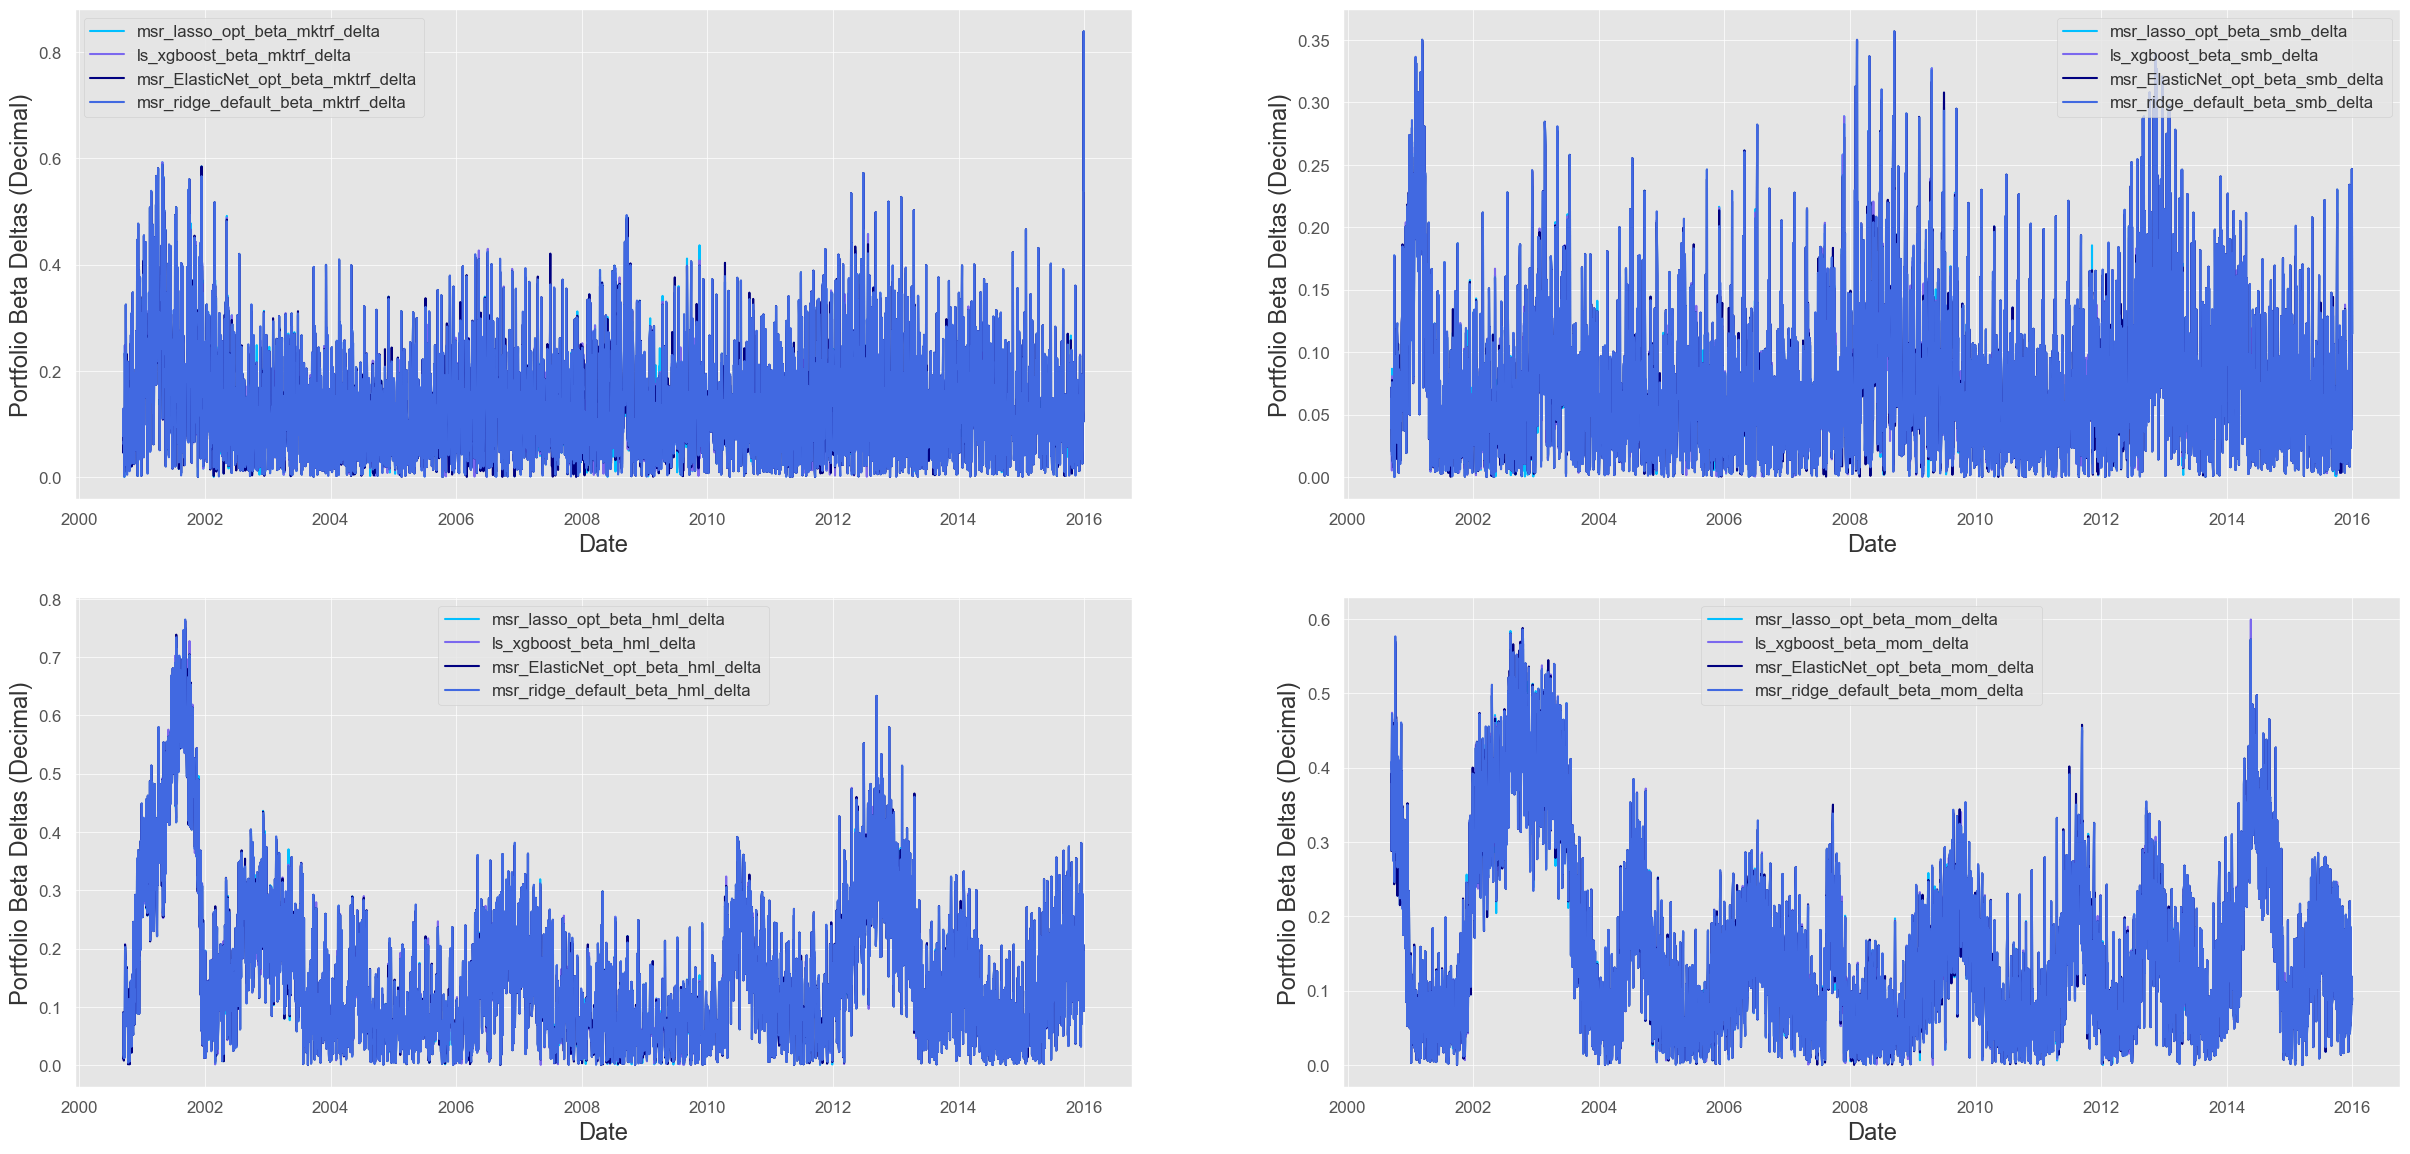

In [27]:
beta_names = ['beta_mktrf', 'beta_smb', 'beta_hml', 'beta_mom']
colors = ['deepskyblue', 'mediumslateblue', 'navy', 'royalblue']
idx = 0
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 14))
for row in ax:
    for col in row:
        betas_to_plot = [col for col in model_beta_pct_change if beta_names[idx] in col]
        temp = model_beta_pct_change[['date'] + betas_to_plot].set_index('date')
        
        lines = col.plot(model_beta_pct_change[['date'] + betas_to_plot].set_index('date'))
        for i in range(len(lines)):
            lines[i].set_color(colors[i])
            
        col.legend(betas_to_plot)
        col.set_xlabel('Date', fontsize = 17)
        col.set_ylabel('Portfolio Beta Deltas (Decimal)', fontsize = 17)
        
        # yticks = np.linspace(col.get_ylim()[0], col.get_ylim()[1], num = 5)
        # yticklabels = ['-0.05', '-0.025', '0', '0.025', '0.05']
        # col.set_yticks(yticks)
        # col.set_yticklabels(yticklabels)
        
        idx += 1

### Plot cumulative returns vs. benchmark for two best strategies (msr_lasso_opt, mvp_lasso)

In [17]:
benchmark_metrics = benchmark.loc[benchmark['date'] >= '2000-09-11'][['date', 'return']].set_index('date')

In [18]:
msr_lasso_opt_metrics = train_returns_msr_linear.loc[train_returns_msr_linear['date'] >= '2000-09-11'][['date', 'msr_lasso_opt']].set_index('date')
msr_lasso_opt_metrics = msr_lasso_opt_metrics.rename(columns = {'msr_lasso_opt': 'return'})

ls_xgboost_metrics = train_returns_ls_xgboost.loc[train_returns_ls_xgboost['date'] >= '2000-09-11'][['date', 'ls_xgboost']].set_index('date')
ls_xgboost_metrics = ls_xgboost_metrics.rename(columns = {'ls_xgboost': 'return'})

best_metrics = {'benchmark': benchmark_metrics,
                'msr_lasso_opt': msr_lasso_opt_metrics,
                'ls_xgboost': ls_xgboost_metrics}

benchmark        0.448355
msr_lasso_opt    0.439627
ls_xgboost       0.438724
dtype: float64


,benchmark,msr_lasso_opt,ls_xgboost
date,,,
2000-09-11,-0.000842,0.001486,0.001486
2000-09-12,0.001840,-0.000783,-0.000783
2000-09-13,-0.000696,-0.014744,-0.014745
2000-09-14,-0.016182,-0.009391,-0.010278
2000-09-15,-0.009545,-0.003777,-0.004224
...,...,...,...
2015-12-24,-0.000626,-0.000992,-0.000992
2015-12-28,-0.001044,0.007605,0.007613
2015-12-29,0.008090,-0.003681,-0.003681


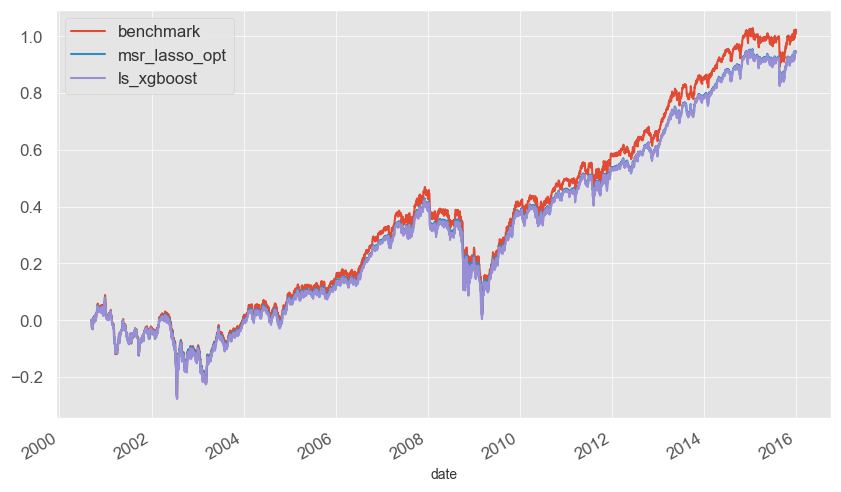

In [19]:
utils.get_metrics(best_metrics)

### Plot cumulative returns vs. benchmark for two worst strategies (msr_rforest, msr_ridge_default)

In [20]:
msr_ElasticNet_opt_metrics = train_returns_msr_elasticnet.loc[train_returns_msr_elasticnet['date'] >= '2000-09-11'][['date', 'msr_ElasticNet_opt']].set_index('date')
msr_ElasticNet_opt_metrics = msr_ElasticNet_opt_metrics.rename(columns = {'msr_ElasticNet_opt': 'return'})

msr_ridge_default_metrics = train_returns_msr_linear.loc[train_returns_msr_linear['date'] >= '2000-09-11'][['date', 'msr_ridge_default']].set_index('date')
msr_ridge_default_metrics = msr_ridge_default_metrics.rename(columns = {'msr_ridge_default': 'return'})

worst_metrics = {'benchmark': benchmark_metrics,
                 'msr_ElasticNet_opt': msr_ElasticNet_opt_metrics,
                 'msr_ridge_default': msr_ridge_default_metrics}

benchmark             0.448355
msr_ElasticNet_opt    0.432891
msr_ridge_default     0.426618
dtype: float64


,benchmark,msr_ElasticNet_opt,msr_ridge_default
date,,,
2000-09-11,-0.000842,0.001485,0.001486
2000-09-12,0.001840,-0.000783,-0.000973
2000-09-13,-0.000696,-0.014744,-0.015343
2000-09-14,-0.016182,-0.009392,-0.009843
2000-09-15,-0.009545,-0.004736,-0.004805
...,...,...,...
2015-12-24,-0.000626,-0.000992,-0.000992
2015-12-28,-0.001044,0.007605,0.007605
2015-12-29,0.008090,-0.003681,-0.003681


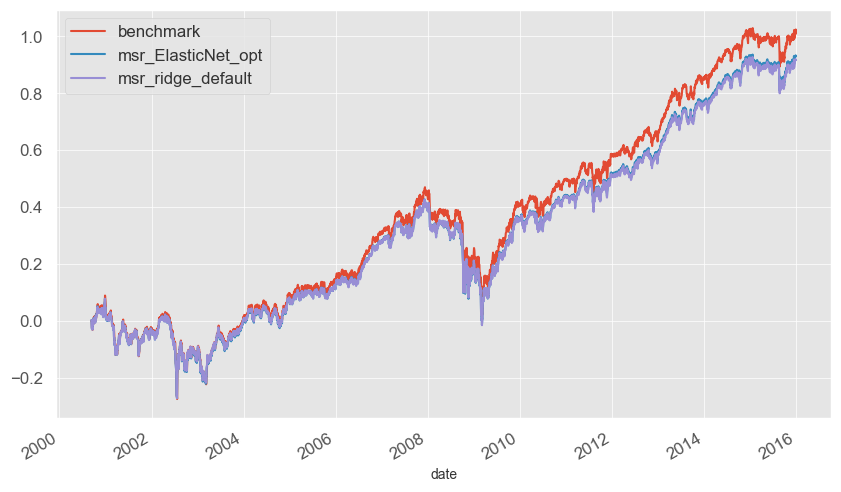

In [21]:
utils.get_metrics(worst_metrics)

### Plot QuantStats report for best model/strategy (msr_lasso_opt)

Sharpe ratio = 0.43962735313071943
Average daily return (bps)= 2.453534783052266
-------------


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-09-11  2000-09-11
End Period                 2015-12-31  2015-12-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          121.2%      132.45%
CAGR﹪                     5.32%       5.66%

Sharpe                     0.44        0.45
Prob. Sharpe Ratio         95.76%      96.05%
Smart Sharpe               0.4         0.41
Sortino                    0.63        0.64
Smart Sortino              0.57        0.58
Sortino/√2                 0.44        0.45
Smart Sortino/√2           0.41        0.41
Omega                      1.08        1.08

Max Drawdown               -37.23%     -39.22%
Longest DD Days            1828        1811
Volatility (ann.)          14.06%      14.73%
R^2                        0.01        0.01
Information Ratio          -0.0        -0.0
Calmar                     0.14      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-10,2009-03-06,2011-04-26,1233,-37.225053,-32.824552
2,2000-12-28,2002-07-22,2005-12-30,1828,-30.793306,-26.867578
3,2015-01-22,2015-08-24,2015-12-31,343,-12.305063,-11.118982
4,2011-05-19,2011-08-09,2011-12-20,215,-10.642322,-7.961315
5,2012-10-18,2012-11-14,2013-01-17,91,-6.201883,-6.046965


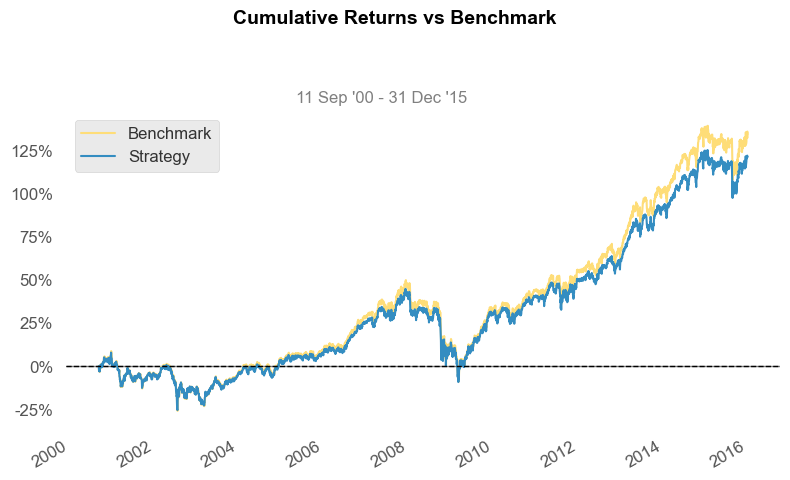

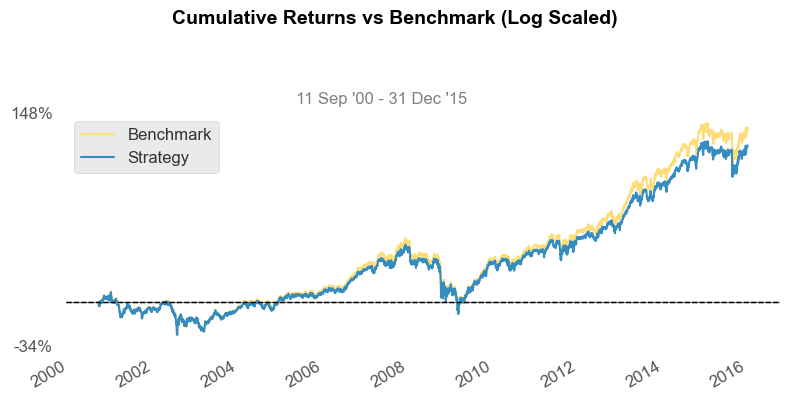

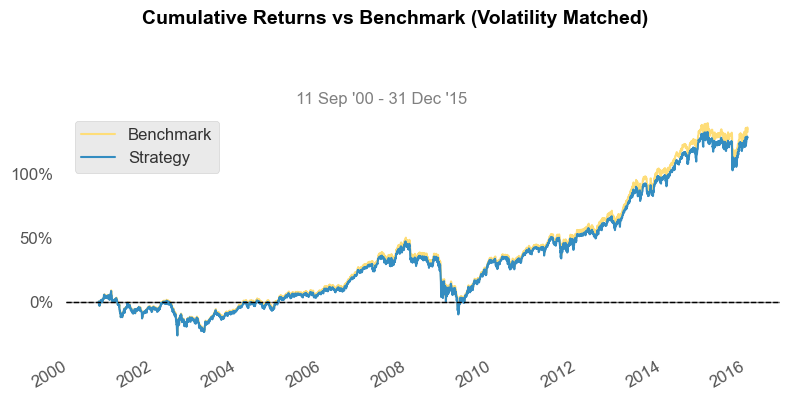

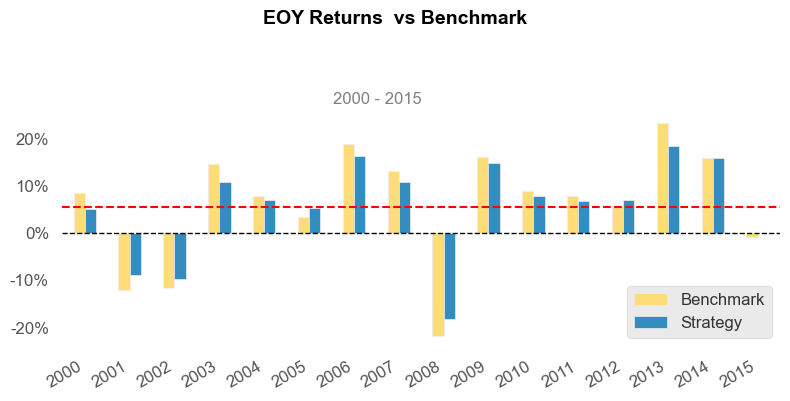

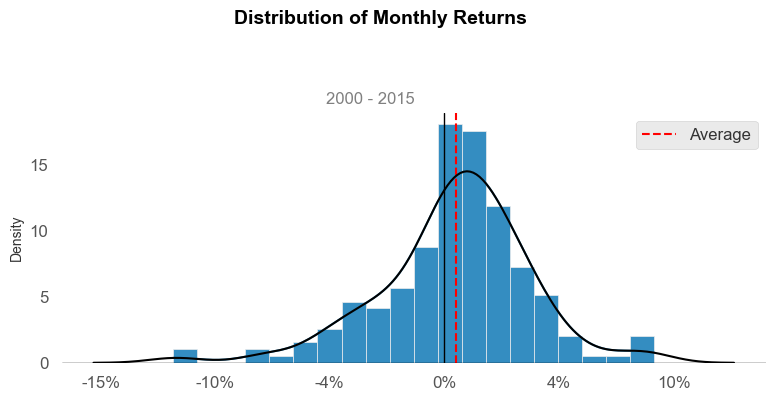

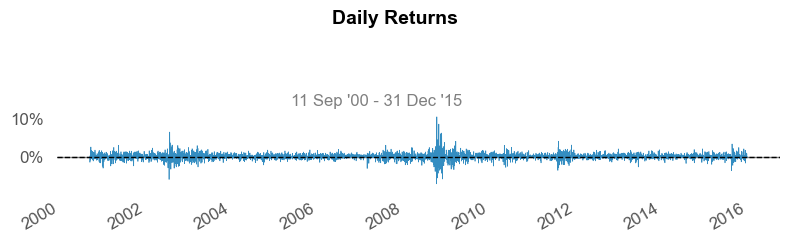

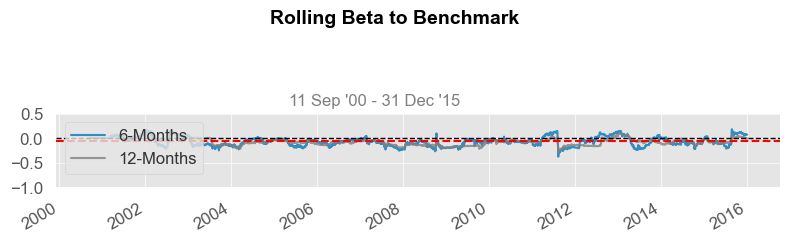

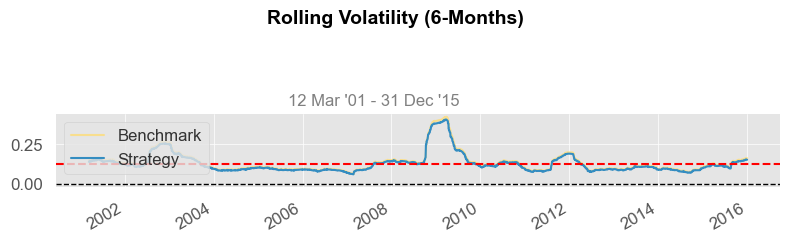

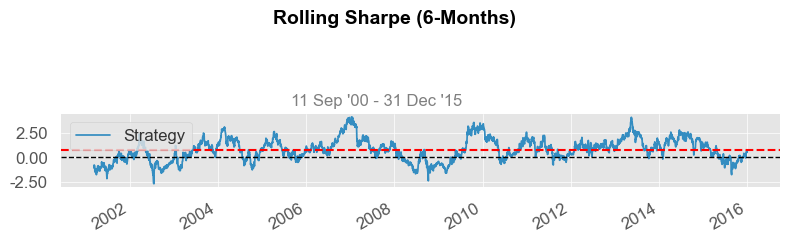

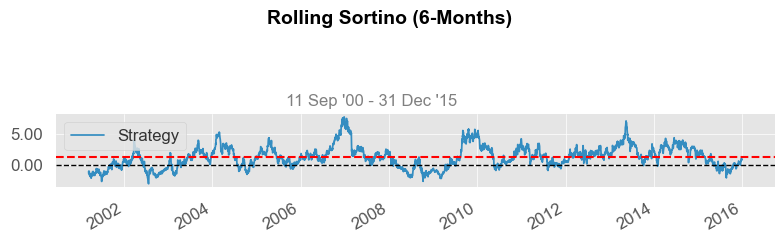

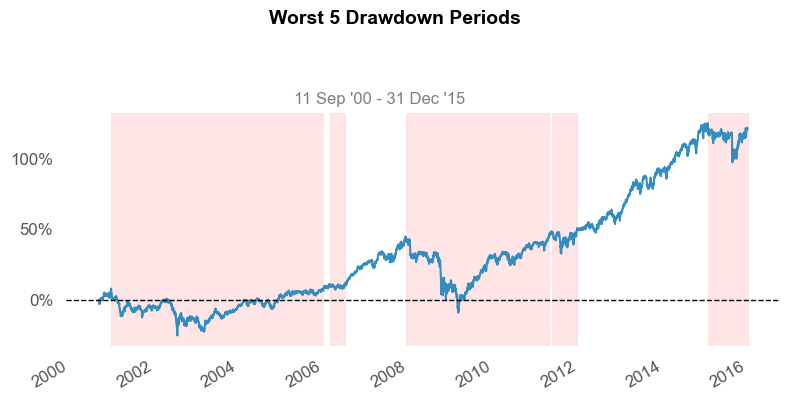

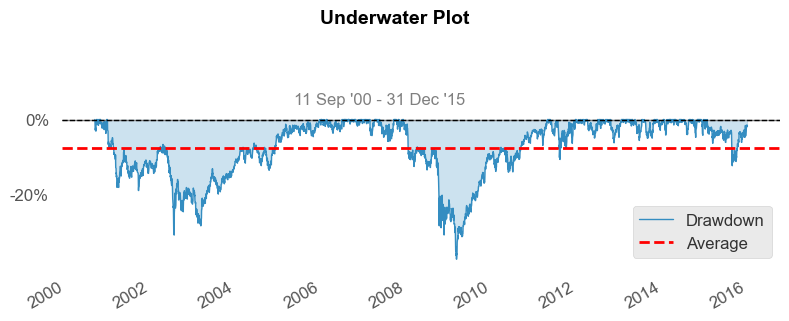

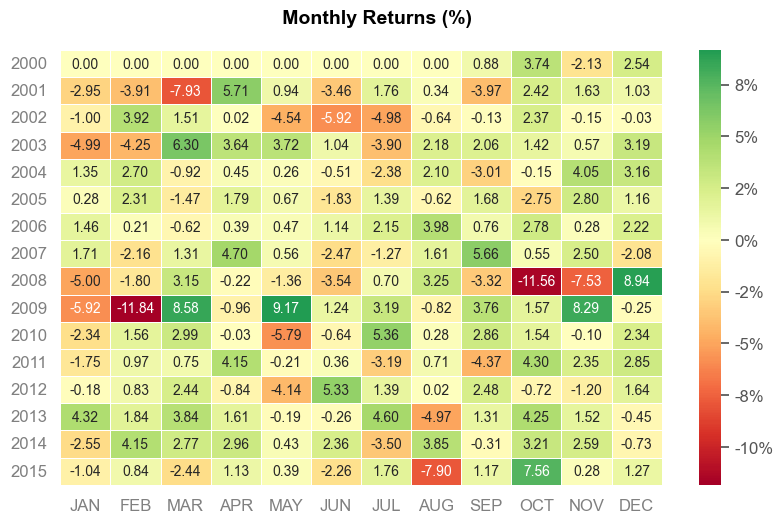

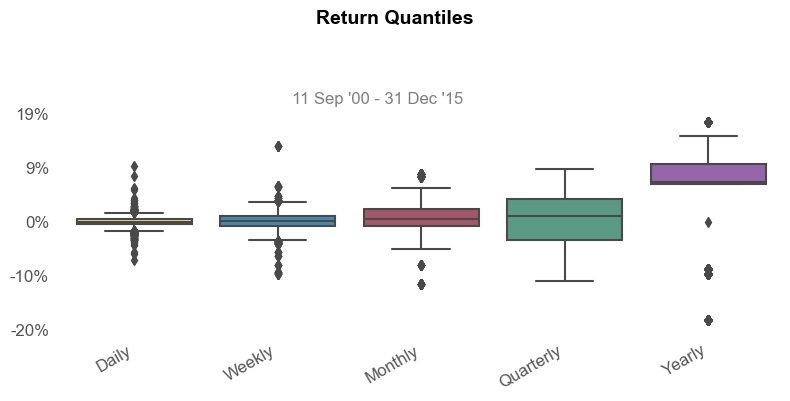

In [23]:
utils.perform_trading_analysis(train_returns, 'msr_lasso_opt', benchmark_metrics)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0dbfd423-fa3a-4cf9-b7ab-66e1f2070500' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>